# Next-Token Trace Analysis (True vs Predicted Across Layers)

This notebook analyzes decoder traces created by `src/cli/extract_trace_nexttok_dec.py`.
It compares **true next token** vs **model-predicted token** (and strongest wrong competitor) across layers.

In [10]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src.traces_utils.store import TraceStore
from src.models.load import load_base

plt.style.use("seaborn-v0_8-whitegrid")

In [ ]:
RUN_DIR = Path(r"C:\traces\wt2_gpt2large_hidden")

MAX_EXAMPLES = None 

assert RUN_DIR.exists(), f"Trace run not found: {RUN_DIR}"

WindowsPath('C:/traces/wt2_gpt2large_hidden')

In [12]:
st = TraceStore(str(RUN_DIR))
df = st.tokens.copy().reset_index(drop=True)

required_cols = [
    "next_pos", "next_true_id", "next_pred_id", "next_correct", "next_topk_ids"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns in tokens.parquet: {missing}")

print("meta:", json.dumps(st.meta, indent=2))
print("arrays:", st.arrays())
print("rows:", len(df))
print("valid next-pos rows:", int((df["next_pos"] >= 0).sum()))

meta: {
  "run_id": "wt2_gpt2large_hidden",
  "model": "gpt2-large",
  "arch": "dec",
  "objective": "next_token",
  "dataset": "wikitext2",
  "split": "validation",
  "n_examples": 200,
  "max_seq_len": 256,
  "num_layers": 36,
  "num_heads": 20,
  "head_dim": 64,
  "dtype": "float16",
  "capture": [
    "hidden"
  ],
  "next_topk": 5,
  "next_token_examples": 200,
  "next_token_acc": 0.055,
  "next_token_true_prob_mean": 0.046986790396614,
  "time": "2026-02-10 23:01:57"
}
arrays: {'dec_hidden': (200, 37, 256, 1280)}
rows: 200
valid next-pos rows: 200


In [13]:
model_id = st.meta.get("model", "gpt2")
tok, model, device = load_base(model_id)
model.eval()

if not hasattr(model, "lm_head"):
    raise RuntimeError("Expected decoder LM with lm_head for next-token analysis.")

W = model.lm_head.weight.detach().cpu()  
ln_f = model.transformer.ln_f

arr = st.arrays()
if "dec_hidden" not in arr:
    raise RuntimeError("Trace has no dec_hidden; rerun extraction with --capture hidden.")

L_plus_1 = int(arr["dec_hidden"][1])
L = L_plus_1 - 1
print("model:", model_id)
print("device:", device)
print("L+1:", L_plus_1, "(final layer index:", L, ")")

model: gpt2-large
device: cpu
L+1: 37 (final layer index: 36 )


In [14]:
def project_for_logitlens(h_vec: np.ndarray, layer_idx: int) -> torch.Tensor:
    """
    For GPT-2 hidden states:
      - layers < L are pre-final-LN -> apply ln_f
      - layer L is already final representation -> do not apply ln_f again
    """
    h = torch.as_tensor(h_vec, dtype=torch.float32)
    if layer_idx < L:
        return ln_f(h.unsqueeze(0)).squeeze(0).detach().cpu()
    return h


def pick_alt_id(row: pd.Series) -> int:
    true_id = int(row["next_true_id"])
    pred_id = int(row["next_pred_id"])
    if pred_id != true_id:
        return pred_id

    ids = row.get("next_topk_ids", None)
    if isinstance(ids, (list, tuple, np.ndarray)):
        for t in ids:
            tid = int(t)
            if tid != true_id:
                return tid
    return pred_id


def layer_curves_for_row(row: pd.Series) -> dict:
    pos = int(row["next_pos"])
    if pos < 0:
        return {}

    eid = row["example_id"]
    H = st.hidden(eid, side="dec")  # (L+1, T, D)

    true_id = int(row["next_true_id"])
    pred_id = int(row["next_pred_id"])
    alt_id = int(pick_alt_id(row))

    ids = [true_id, pred_id, alt_id]
    W_sub = W[ids]  # (3, D)

    logit_true = np.zeros(L_plus_1, dtype=np.float32)
    logit_pred = np.zeros(L_plus_1, dtype=np.float32)
    logit_alt = np.zeros(L_plus_1, dtype=np.float32)

    for li in range(L_plus_1):
        h = project_for_logitlens(H[li, pos], li)
        logits = torch.mv(W_sub, h).numpy()
        logit_true[li], logit_pred[li], logit_alt[li] = logits.tolist()

    margin_true_pred = logit_true - logit_pred
    margin_true_alt = logit_true - logit_alt

    # pairwise (2-token) probability of true token over competitor
    p_true_over_pred = 1.0 / (1.0 + np.exp(-margin_true_pred))
    p_true_over_alt = 1.0 / (1.0 + np.exp(-margin_true_alt))

    return {
        "example_id": eid,
        "pos": pos,
        "true_id": true_id,
        "pred_id": pred_id,
        "alt_id": alt_id,
        "final_correct": bool(row["next_correct"]),
        "logit_true": logit_true,
        "logit_pred": logit_pred,
        "logit_alt": logit_alt,
        "margin_true_pred": margin_true_pred,
        "margin_true_alt": margin_true_alt,
        "p_true_over_pred": p_true_over_pred,
        "p_true_over_alt": p_true_over_alt,
    }

In [15]:
work_df = df[df["next_pos"] >= 0].copy().reset_index(drop=True)
if MAX_EXAMPLES is not None:
    work_df = work_df.head(int(MAX_EXAMPLES)).reset_index(drop=True)

rows = []
for _, r in tqdm(work_df.iterrows(), total=len(work_df)):
    out = layer_curves_for_row(r)
    if out:
        rows.append(out)

print("analyzed examples:", len(rows))
acc = float(np.mean([r["final_correct"] for r in rows])) if rows else float("nan")
print("final next-token accuracy in analyzed subset:", round(acc, 4))

M_true_pred = np.stack([r["margin_true_pred"] for r in rows], axis=0)
M_true_alt = np.stack([r["margin_true_alt"] for r in rows], axis=0)
P_true_pred = np.stack([r["p_true_over_pred"] for r in rows], axis=0)
P_true_alt = np.stack([r["p_true_over_alt"] for r in rows], axis=0)
is_correct = np.array([r["final_correct"] for r in rows], dtype=bool)

  0%|          | 0/200 [00:00<?, ?it/s]

analyzed examples: 200
final next-token accuracy in analyzed subset: 0.055


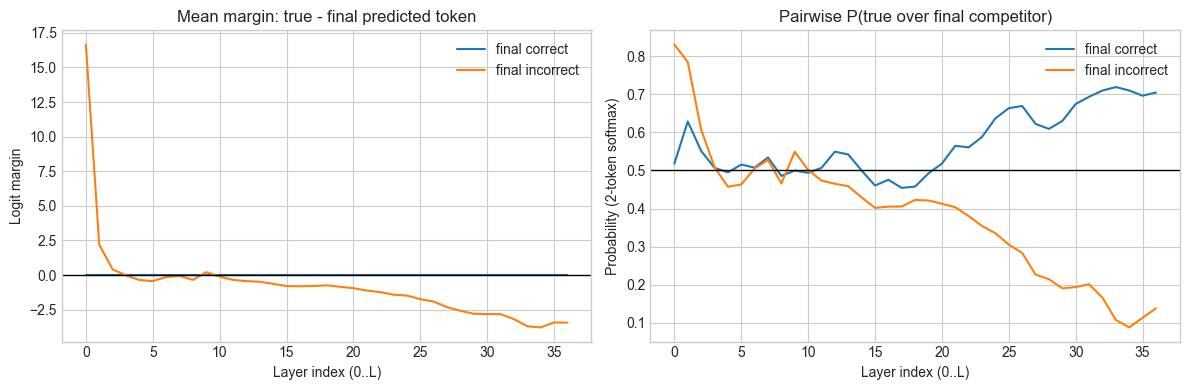

In [16]:
layers = np.arange(L_plus_1)

def mean_curve(mat: np.ndarray, mask: np.ndarray):
    if mask.sum() == 0:
        return np.full(mat.shape[1], np.nan)
    return mat[mask].mean(axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(layers, mean_curve(M_true_pred, is_correct), label="final correct")
plt.plot(layers, mean_curve(M_true_pred, ~is_correct), label="final incorrect")
plt.axhline(0.0, color="black", linewidth=1)
plt.title("Mean margin: true - final predicted token")
plt.xlabel("Layer index (0..L)")
plt.ylabel("Logit margin")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(layers, mean_curve(P_true_alt, is_correct), label="final correct")
plt.plot(layers, mean_curve(P_true_alt, ~is_correct), label="final incorrect")
plt.axhline(0.5, color="black", linewidth=1)
plt.title("Pairwise P(true over final competitor)")
plt.xlabel("Layer index (0..L)")
plt.ylabel("Probability (2-token softmax)")
plt.legend()

plt.tight_layout()
plt.show()

stable-positive found (all): 11 / 200
mean stable layer (correct): 21.363636363636363
mean stable layer (incorrect): None


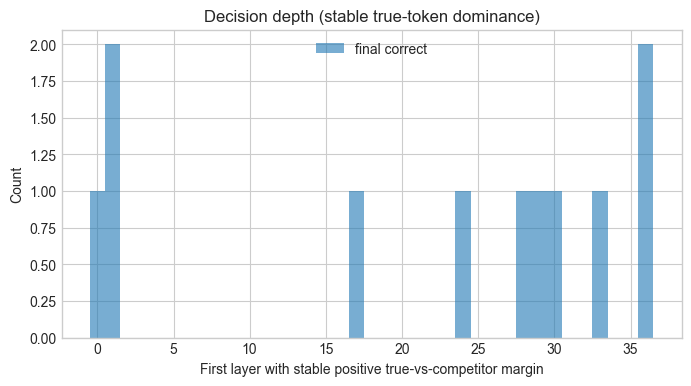

In [17]:
def first_stable_positive(margin: np.ndarray):
    for i in range(len(margin)):
        if np.all(margin[i:] > 0):
            return i
    return None

depths = [first_stable_positive(r["margin_true_alt"]) for r in rows]
d_ok = [d for d, c in zip(depths, is_correct) if c and d is not None]
d_bad = [d for d, c in zip(depths, is_correct) if (not c) and d is not None]

print("stable-positive found (all):", sum(d is not None for d in depths), "/", len(depths))
print("mean stable layer (correct):", np.mean(d_ok) if d_ok else None)
print("mean stable layer (incorrect):", np.mean(d_bad) if d_bad else None)

plt.figure(figsize=(8, 4))
if d_ok:
    plt.hist(d_ok, bins=np.arange(L_plus_1 + 1) - 0.5, alpha=0.6, label="final correct")
if d_bad:
    plt.hist(d_bad, bins=np.arange(L_plus_1 + 1) - 0.5, alpha=0.6, label="final incorrect")
plt.xlabel("First layer with stable positive true-vs-competitor margin")
plt.ylabel("Count")
plt.title("Decision depth (stable true-token dominance)")
plt.legend()
plt.show()

example_id: 18dafe4ddf447773
final_correct: False
next_pos: 137
true token: 257 ' a'
pred token: 373 ' was'
alt token : 373 ' was'
text preview: Air Vice Marshal Frank Headlam , CB , CBE ( 15 July 1914 – 23 December 1976 ) was a senior commander in the Royal Australian Air Force ( RAAF ) . Born and educated in Tasmania , he joined the RAAF as an air cadet in January 1934 . He specialised in flying instruction and navigation before the outbreak of World War II . In April 1941 , he became commanding officer of No. 2 Squadron , which operated Lockheed Hudsons . The squadron was deployed to Dutch Timor in December , and saw action against Ja


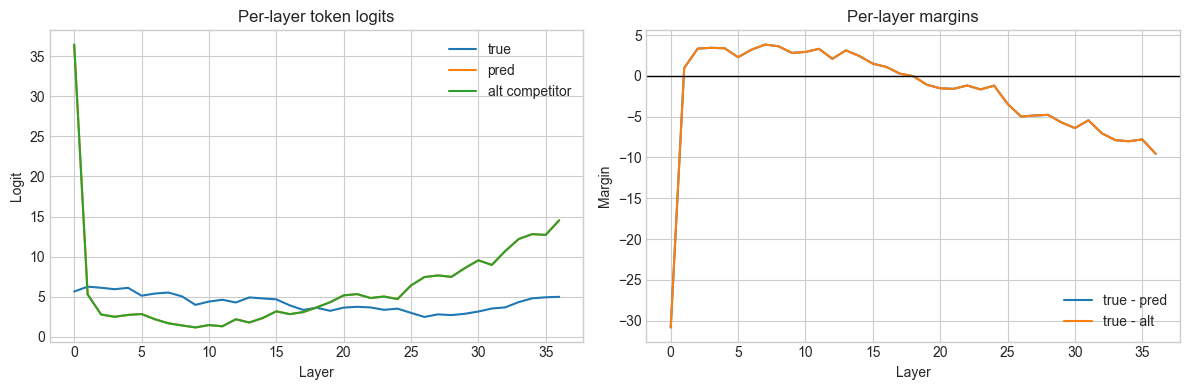

In [20]:
# Per-example explorer
EXAMPLE_IDX = 32  # look through indexes
r = rows[EXAMPLE_IDX]
raw = df[df["example_id"] == r["example_id"]].iloc[0]

print("example_id:", r["example_id"])
print("final_correct:", r["final_correct"])
print("next_pos:", r["pos"])
print("true token:", r["true_id"], repr(tok.decode([r["true_id"]])))
print("pred token:", r["pred_id"], repr(tok.decode([r["pred_id"]])))
print("alt token :", r["alt_id"], repr(tok.decode([r["alt_id"]])))
print("text preview:", raw["text"][:500])

x = np.arange(L_plus_1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, r["logit_true"], label="true")
plt.plot(x, r["logit_pred"], label="pred")
plt.plot(x, r["logit_alt"], label="alt competitor")
plt.xlabel("Layer")
plt.ylabel("Logit")
plt.title("Per-layer token logits")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, r["margin_true_pred"], label="true - pred")
plt.plot(x, r["margin_true_alt"], label="true - alt")
plt.axhline(0.0, color="black", linewidth=1)
plt.xlabel("Layer")
plt.ylabel("Margin")
plt.title("Per-layer margins")
plt.legend()
plt.tight_layout()
plt.show()

## Notes
- `layer 0` is embedding stream; `layer L` is final model representation.
- `margin > 0` means the true token is preferred over the competitor token.
- For final-correct examples, competitor is chosen as the strongest wrong token from `next_topk_ids`.
- For final-incorrect examples, competitor is the model's final predicted token.

In [ ]:
# Top-k + rank metrics (full vocabulary)
valid_df = df[df["next_pos"] >= 0].copy().reset_index(drop=True)
if MAX_EXAMPLES is not None:
    valid_df = valid_df.head(int(MAX_EXAMPLES)).reset_index(drop=True)

ks = [1, 5, 10]
hits = {k: 0 for k in ks}
ranks = []
rrs = []

for _, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
    pos = int(row["next_pos"])
    if pos < 0:
        continue
    eid = row["example_id"]
    true_id = int(row["next_true_id"])

    H = st.hidden(eid, side="dec")
    h = project_for_logitlens(H[-1, pos], L)
    logits = torch.mv(W, h)

    true_logit = logits[true_id]
    rank = int((logits > true_logit).sum().item()) + 1
    ranks.append(rank)
    rrs.append(1.0 / rank)

    for k in ks:
        if rank <= k:
            hits[k] += 1

n = max(1, len(ranks))
print("n_valid:", len(ranks))
for k in ks:
    print(f"hit@{k}: {hits[k] / n:.4f}")
print("mrr:", float(np.mean(rrs)) if rrs else float("nan"))
print("avg_rank:", float(np.mean(ranks)) if ranks else float("nan"))
print("median_rank:", float(np.median(ranks)) if ranks else float("nan"))
